In [1]:
# SIGNAL PROCESSING WITH GW150914 OPEN DATA

In [ ]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz

# the ipython magic below must be commented out in the .py file, since it doesn't work.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib as mpl
import h5py

# LIGO-specific readligo.py 
import readligo as rl

In [ ]:
#----------------------------------------------------------------
# Load LIGO data from a single file
#----------------------------------------------------------------
# First from H1
fn_H1 = 'H-H1_LOSC_4_V1-1126259446-32.hdf5'
strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
# and then from L1
fn_L1 = 'L-L1_LOSC_4_V1-1126259446-32.hdf5'
strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')

# sampling rate:
fs = 4096
# both H1 and L1 will have the same time vector, so:
time=time_H1
# the time sample interval (uniformly sampled!)
dt = time[1] - time[0]

# Adding Numerical Relativity Template

In [18]:
# read in the NR template
NRtime, NR_H1 = np.genfromtxt('GW150914_4_NR_waveform.txt').transpose()

# First Look at H1 and L1

In [19]:
# First, let's look at the data and print out some stuff:

# this doesn't seem to work for scientific notation:
# np.set_printoptions(precision=4)

print '  time_H1: len, min, mean, max = ', \
   len(time_H1), time_H1.min(), time_H1.mean(), time_H1.max()
print 'strain_H1: len, min, mean, max = ', \
   len(strain_H1), strain_H1.min(),strain_H1.mean(),strain_H1.max()
print 'strain_L1: len, min, mean, max = ', \
   len(strain_L1), strain_L1.min(),strain_L1.mean(),strain_L1.max()
    
#What's in chan_dict? See https://losc.ligo.org/archive/dataset/GW150914/
bits = chan_dict_H1['DATA']
print 'H1     DATA: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max()
bits = chan_dict_H1['CBC_CAT1']
print 'H1 CBC_CAT1: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max()
bits = chan_dict_H1['CBC_CAT2']
print 'H1 CBC_CAT2: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max()
bits = chan_dict_L1['DATA']
print 'L1     DATA: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max()
bits = chan_dict_L1['CBC_CAT1']
print 'L1 CBC_CAT1: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max()
bits = chan_dict_L1['CBC_CAT2']
print 'L1 CBC_CAT2: len, min, mean, max = ', len(bits), bits.min(),bits.mean(),bits.max()
print 'In both H1 and L1, all 32 seconds of data are present (DATA=1), '
print "and all pass data quality (CBC_CAT1=1 and CBC_CAT2=1)."

  time_H1: len, min, mean, max =  131072 1126259446.0 1126259462.0 1126259478.0
strain_H1: len, min, mean, max =  131072 -7.11996338709e-19 8.73279794057e-23 7.71483633765e-19
strain_L1: len, min, mean, max =  131072 -2.6788089173e-18 -1.82870749189e-18 -7.69266177024e-19
H1     DATA: len, min, mean, max =  32 1 1.0 1
H1 CBC_CAT1: len, min, mean, max =  32 1 1.0 1
H1 CBC_CAT2: len, min, mean, max =  32 1 1.0 1
L1     DATA: len, min, mean, max =  32 1 1.0 1
L1 CBC_CAT1: len, min, mean, max =  32 1 1.0 1
L1 CBC_CAT2: len, min, mean, max =  32 1 1.0 1
In both H1 and L1, all 32 seconds of data are present (DATA=1), 
and all pass data quality (CBC_CAT1=1 and CBC_CAT2=1).


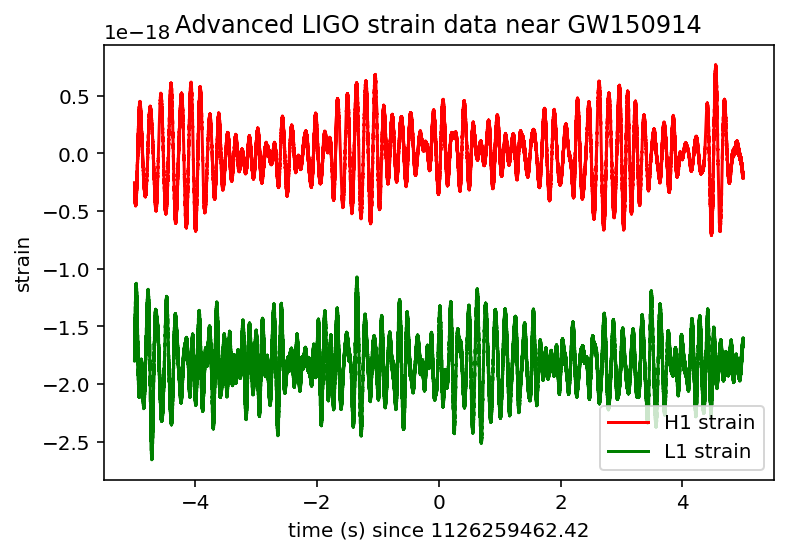

In [6]:
# plot +- 5 seconds around the event:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 5.                     # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

plt.figure()
plt.plot(time_H1[indxt]-tevent,strain_H1[indxt],'r',label='H1 strain')
plt.plot(time_L1[indxt]-tevent,strain_L1[indxt],'g',label='L1 strain')
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower right')
plt.title('Advanced LIGO strain data near GW150914')
plt.savefig('GW150914_strain.png')

The data are dominated by low frequency noise; there is no way to see a signal here, without some signal processing.

There are very low frequency oscillations that are putting the mean of the L1 strain at -2.0e-18 at the time around this event, so it appears offset from the H1 strain. These low frequency oscillations are essentially ignored in LIGO data analysis (see bandpassing, below).

We will be "whitening" the data, below.

Text(0.5,1,u'Advanced LIGO strain data near GW150914')

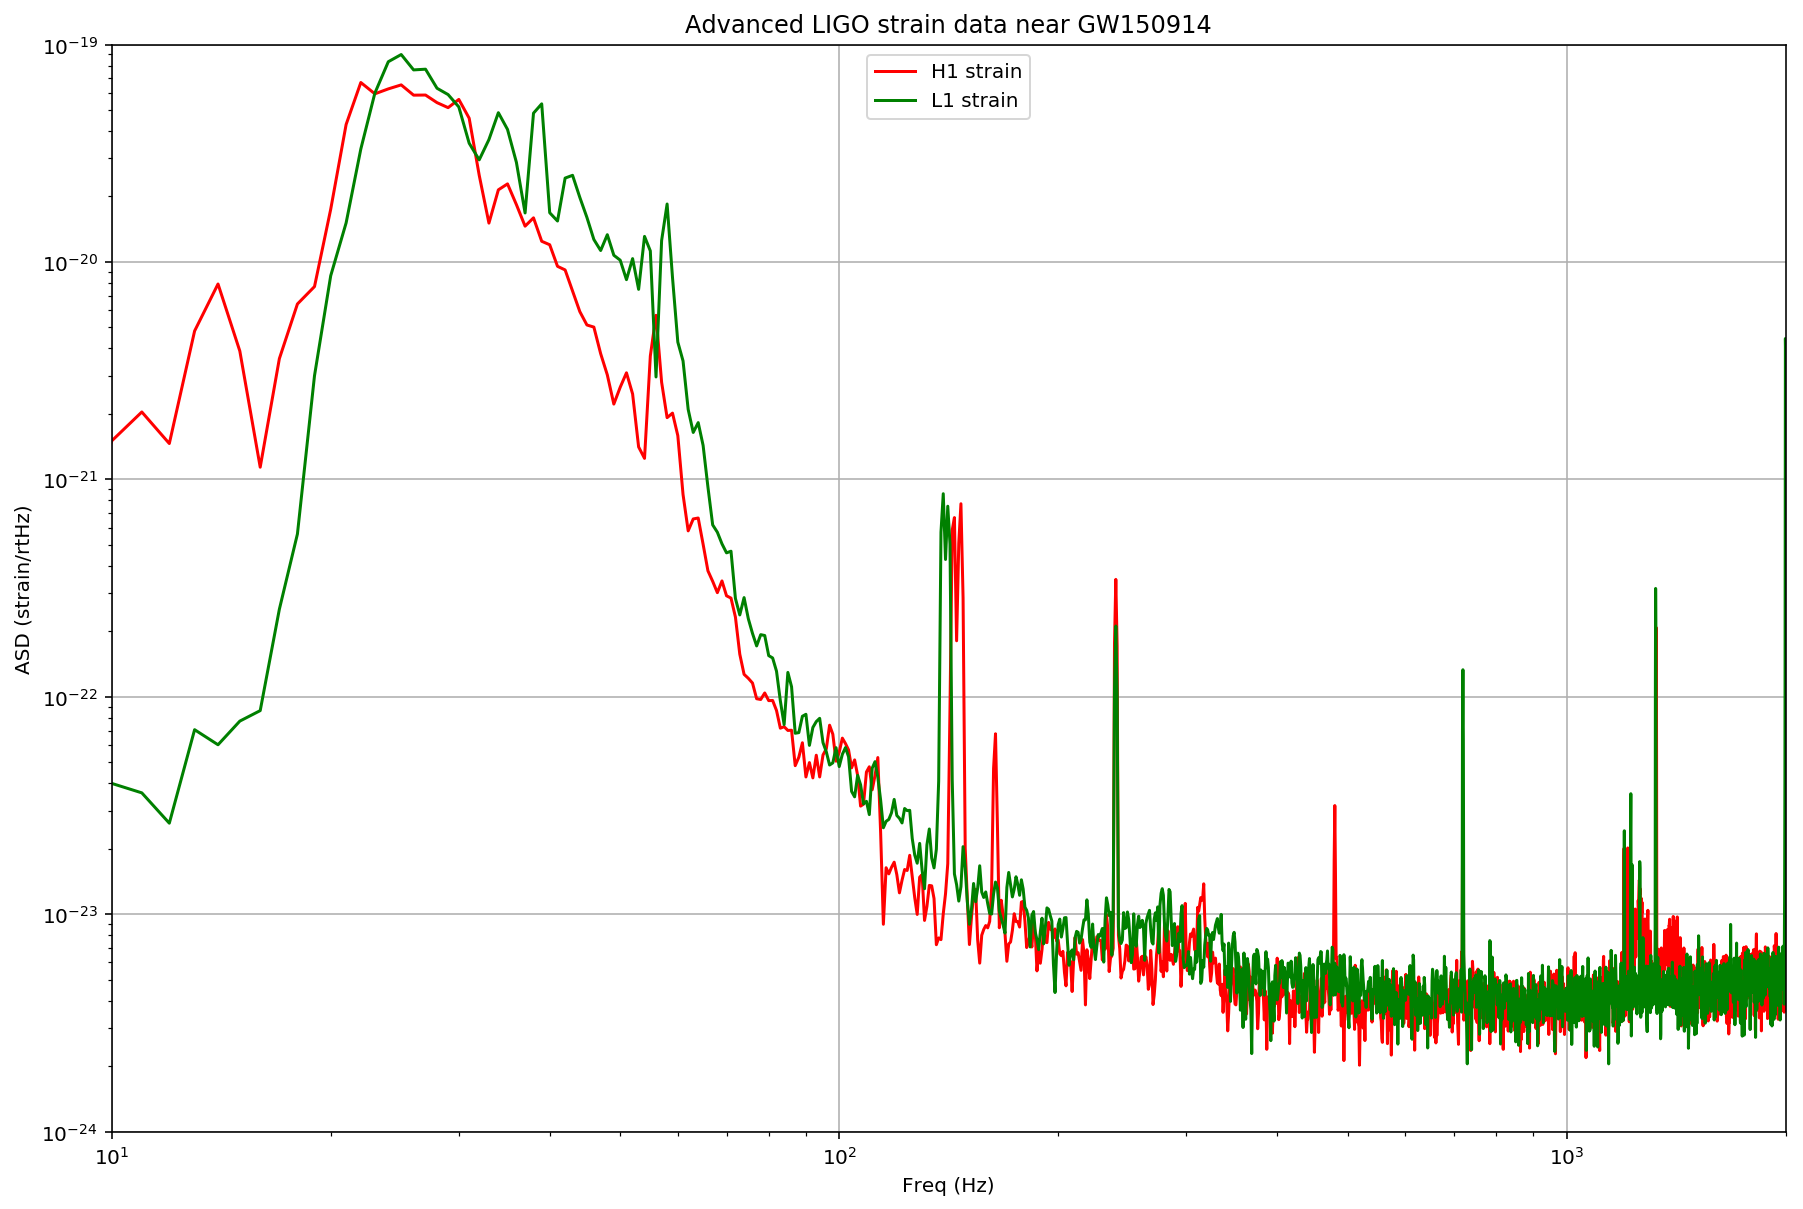

In [20]:
# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx_H1, freqs = mlab.psd(strain_H1, Fs = fs, NFFT = NFFT)
Pxx_L1, freqs = mlab.psd(strain_L1, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_H1 = interp1d(freqs, Pxx_H1)
psd_L1 = interp1d(freqs, Pxx_L1)

# plot the ASDs:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx_H1),'r',label='H1 strain')
plt.loglog(freqs, np.sqrt(Pxx_L1),'g',label='L1 strain')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')
#plt.savefig('GW150914_ASDs.png')

The sample rate is fs = 4096 Hz (2^12 Hz), so the data cannot capture frequency content above the Nyquist frequency = fs/2 = 2048 Hz. That's OK, because GW150914 only has detectable frequency content in the range 20 Hz - 300 Hz.

# Whitening

In [23]:
# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    white_hf = hf / (np.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

# now whiten the data from H1 and L1, and also the NR template:
strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
NR_H1_whiten = whiten(NR_H1,psd_H1,dt)

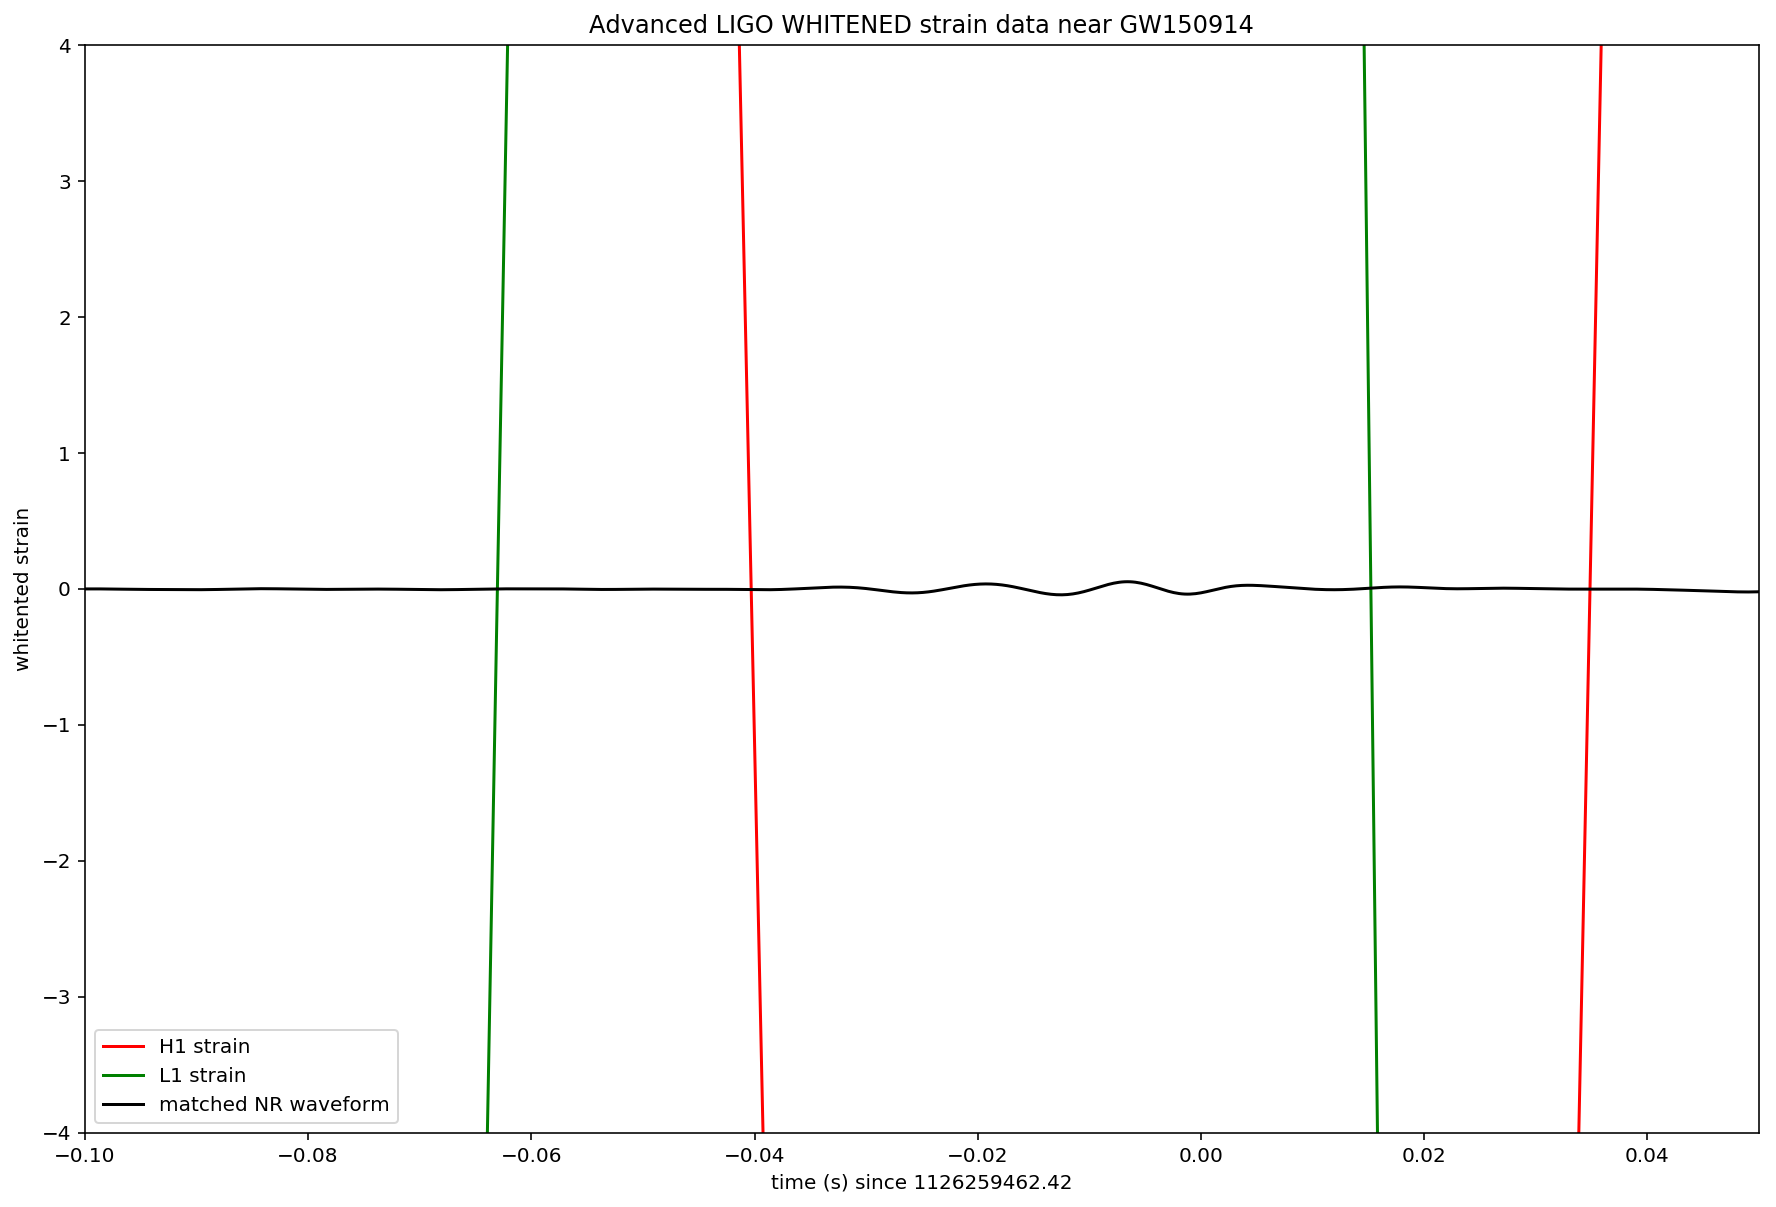

In [24]:
# We need to suppress the high frequencies with some bandpassing:
bb, ab = butter(4, [20.*2./fs, 300.*2./fs], btype='band')
strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten)
strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten)
NR_H1_whitenbp = filtfilt(bb, ab, NR_H1_whiten)

# plot the data after whitening:
# first, shift L1 by 7 ms, and invert. See the GW150914 detection paper for why!
strain_L1_shift = -np.roll(strain_L1_whitenbp,int(0.007*fs))

plt.figure()
plt.plot(time-tevent,strain_H1_whitenbp,'r',label='H1 strain')
plt.plot(time-tevent,strain_L1_shift,'g',label='L1 strain')
plt.plot(NRtime+0.002,NR_H1_whitenbp,'k',label='matched NR waveform')
plt.xlim([-0.1,0.05])
plt.ylim([-4,4])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('whitented strain')
plt.legend(loc='lower left')
plt.title('Advanced LIGO WHITENED strain data near GW150914')
mpl.rcParams["figure.figsize"] = (15,10)
plt.savefig('GW150914_strain_whitened.png')

# Spectrogram

Text(0.5,1,u'aLIGO L1 strain data near GW150914')

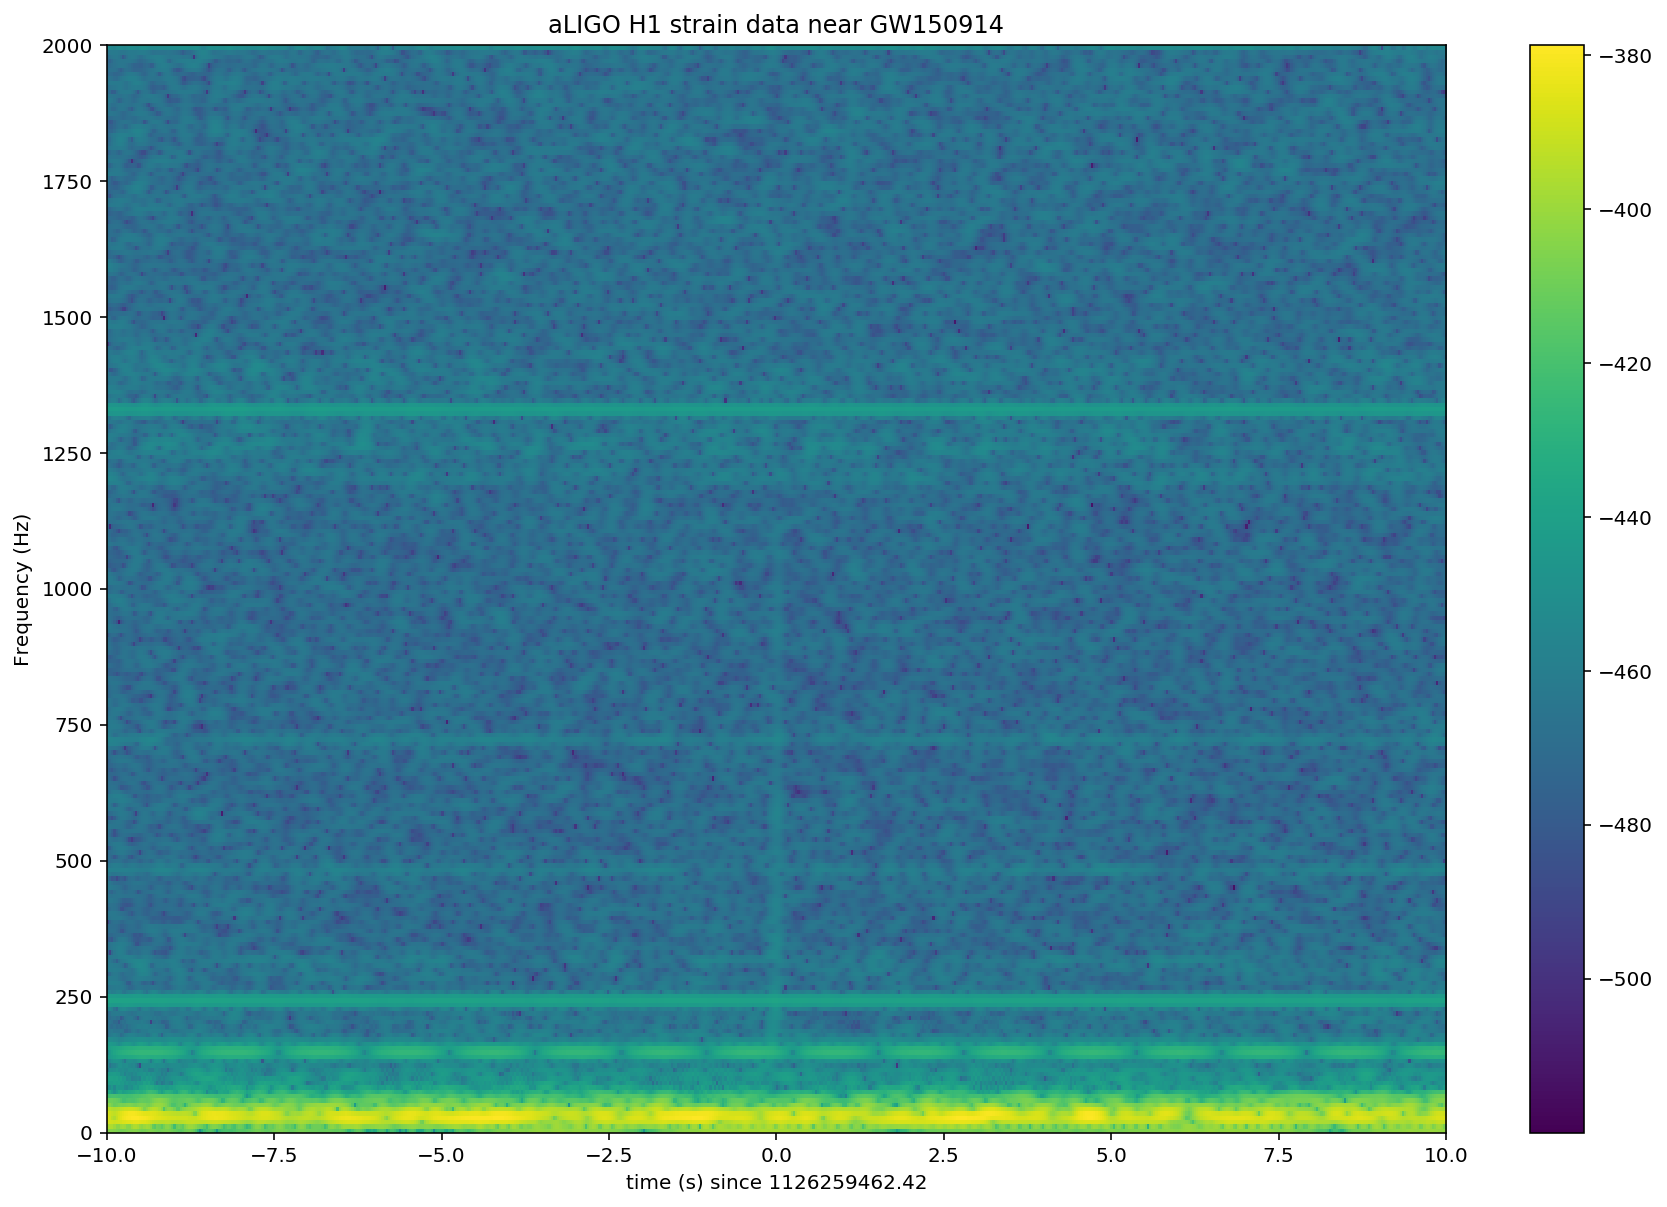

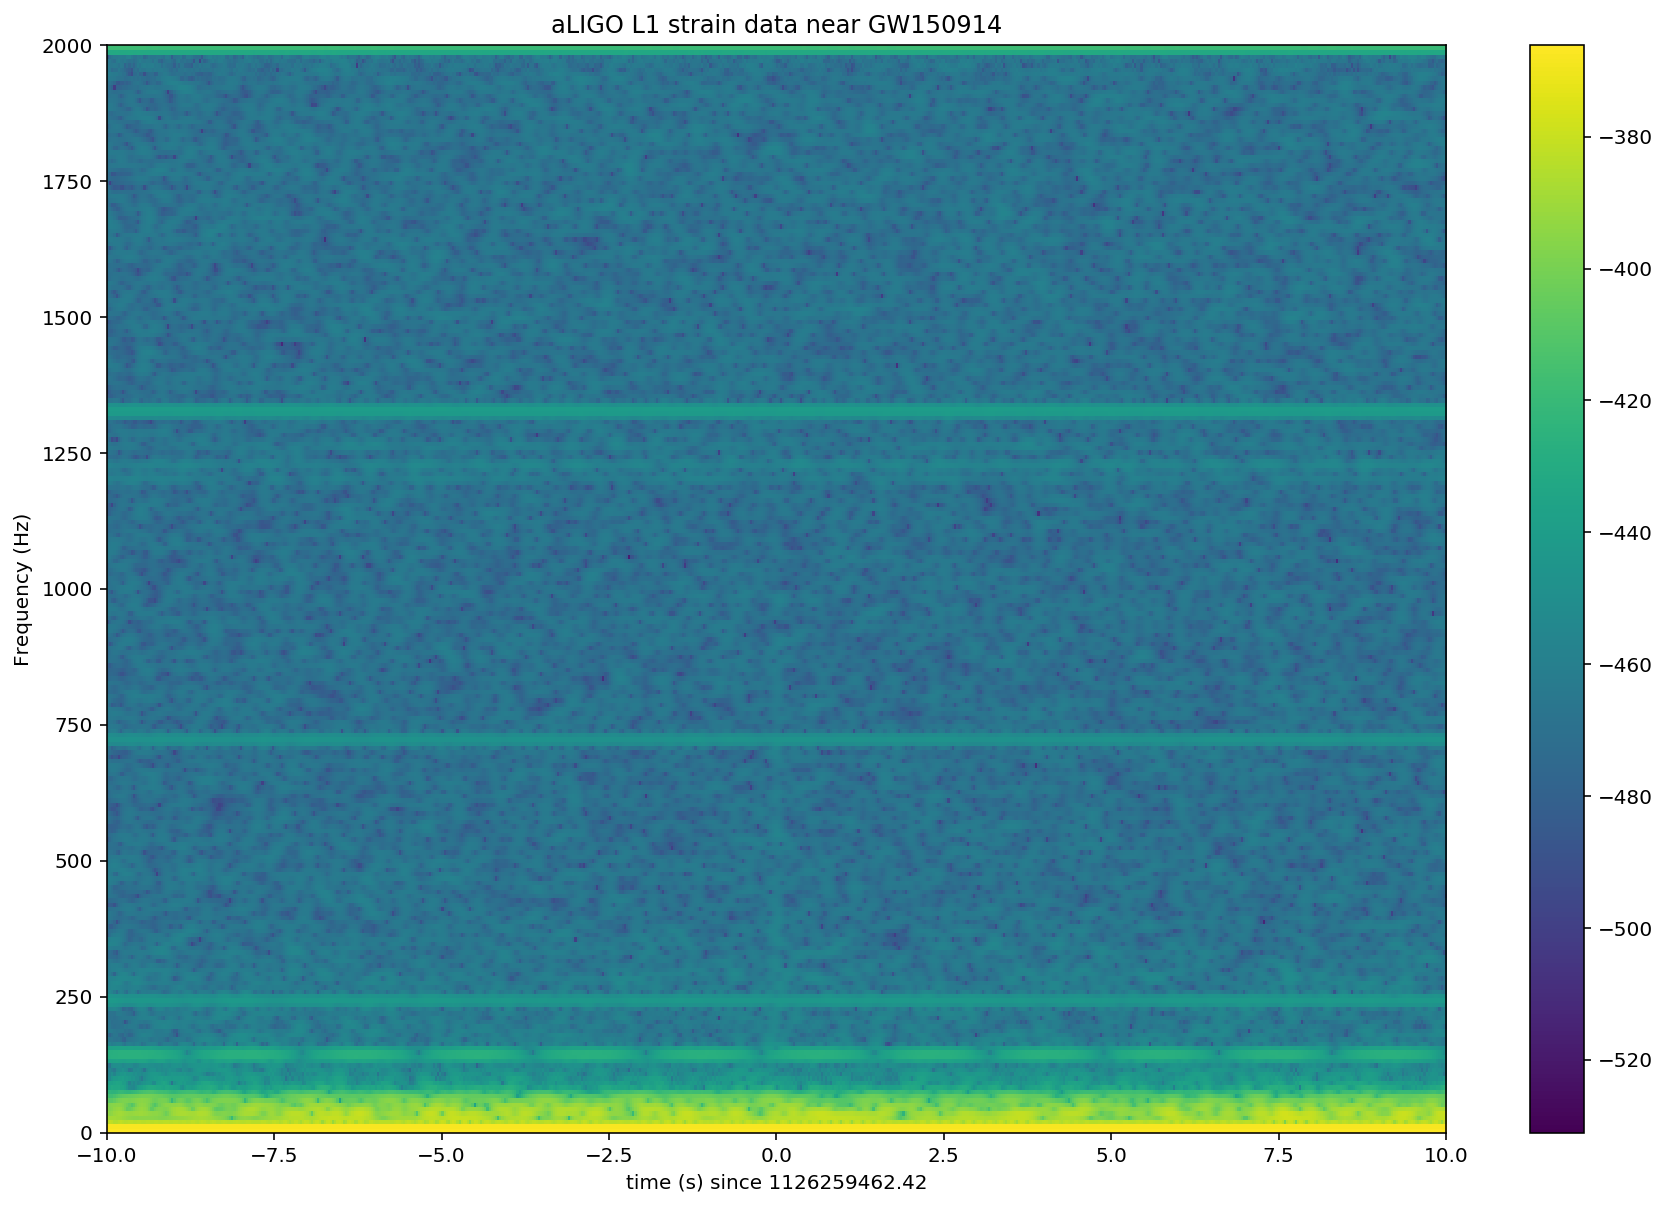

In [25]:
tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 10.                    # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

# pick a shorter FTT time interval, like 1/8 of a second:
NFFT = fs/8
# and with a lot of overlap, to resolve short-time features:
NOVL = NFFT*15/16
# and choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT)

# the right colormap is all-important! See:
# http://matplotlib.org/examples/color/colormaps_reference.html
# viridis seems to be the best for our purposes, but it's new; if you don't have it, you can settle for ocean.
spec_cmap='viridis'
#spec_cmap='ocean'

# Plot the H1 spectrogram:
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_H1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 2000])
plt.title('aLIGO H1 strain data near GW150914')
plt.savefig('GW150914_H1_spectrogram.png')

# Plot the L1 spectrogram:
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_L1[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 2000])
plt.title('aLIGO L1 strain data near GW150914')
#plt.savefig('GW150914_L1_spectrogram.png')


In the above spectrograms, you can see lots of excess power below ~20 Hz, as well as strong spectral lines at 500, 1000, 1500 Hz (also evident in the ASDs above). The lines at multiples of 500 Hz are the harmonics of the "violin modes" of the fibers holding up the mirrors of the LIGO interferometers.

The signal is just bately visible here, at time=0 and below 500 Hz. We need to zoom in around the event time, and to the frequency range from [20, 400] Hz, and use the whitened data generated above.


Text(0.5,1,u'aLIGO L1 strain data near GW150914')

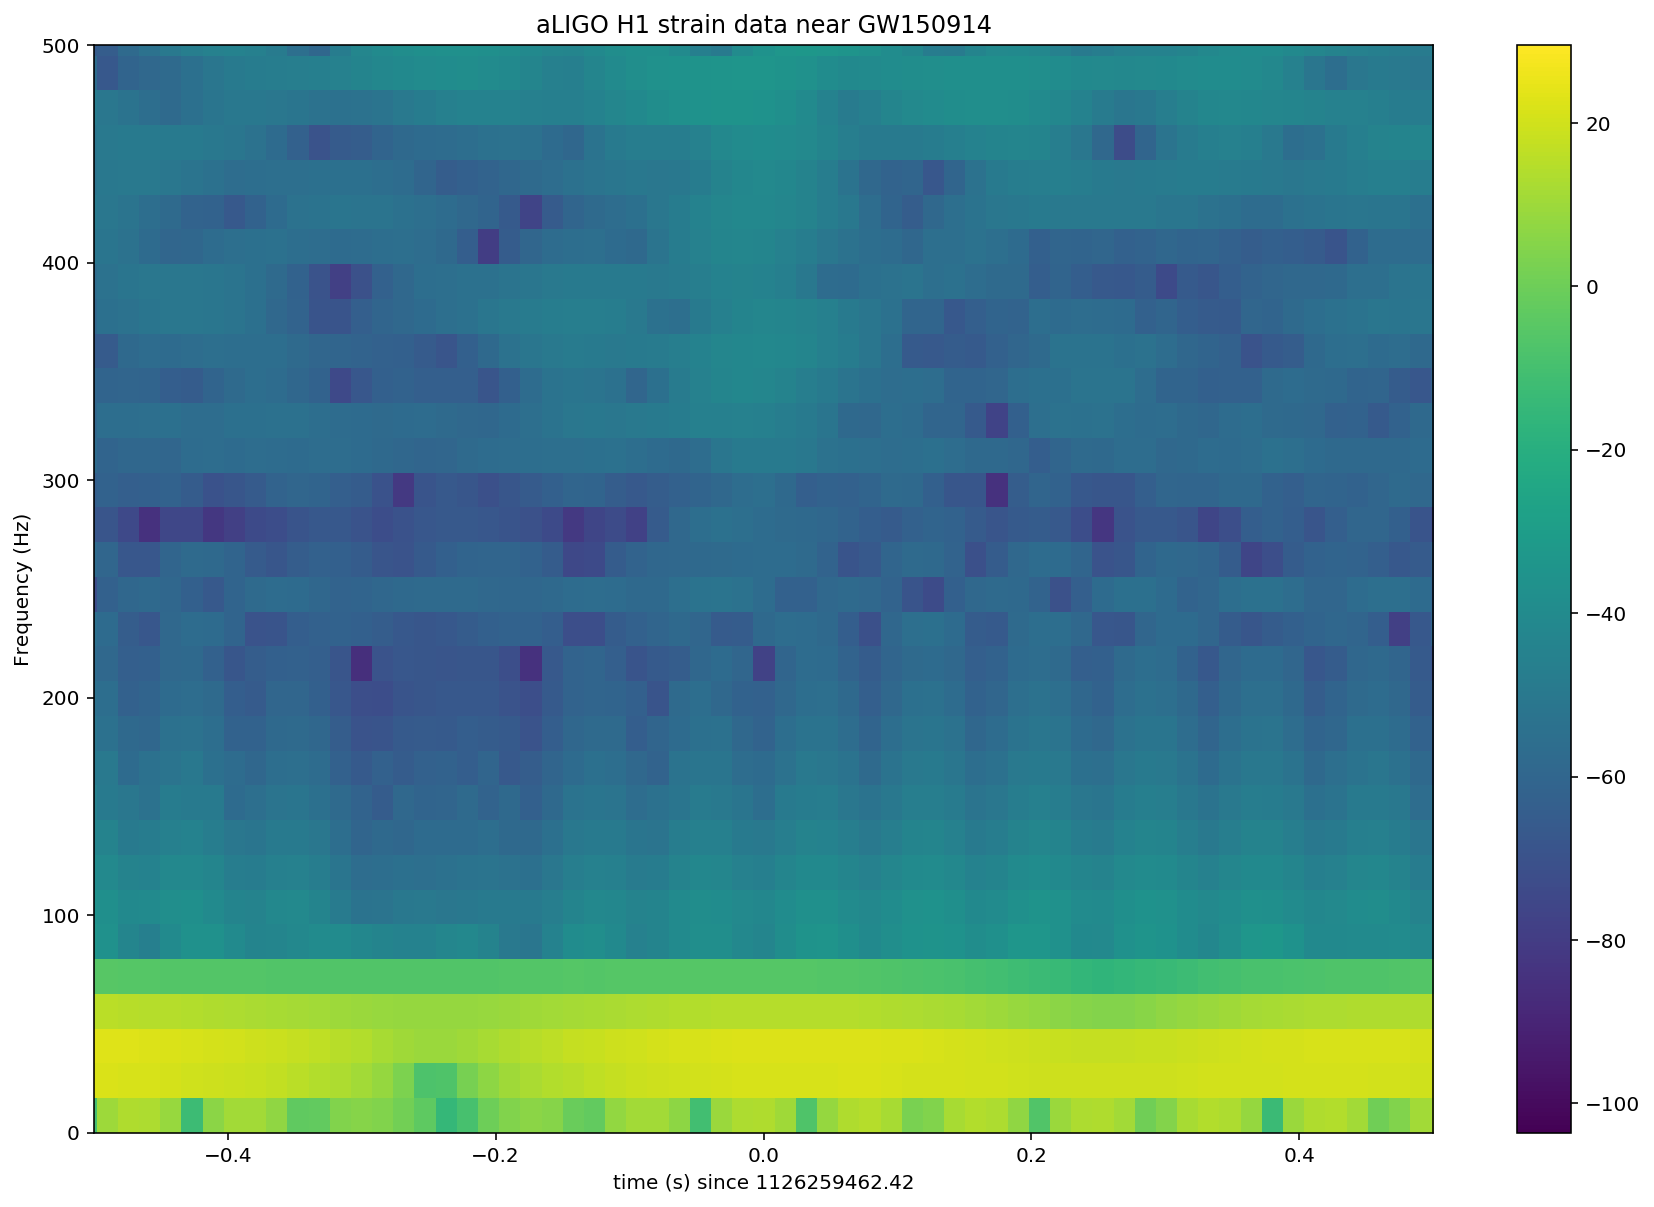

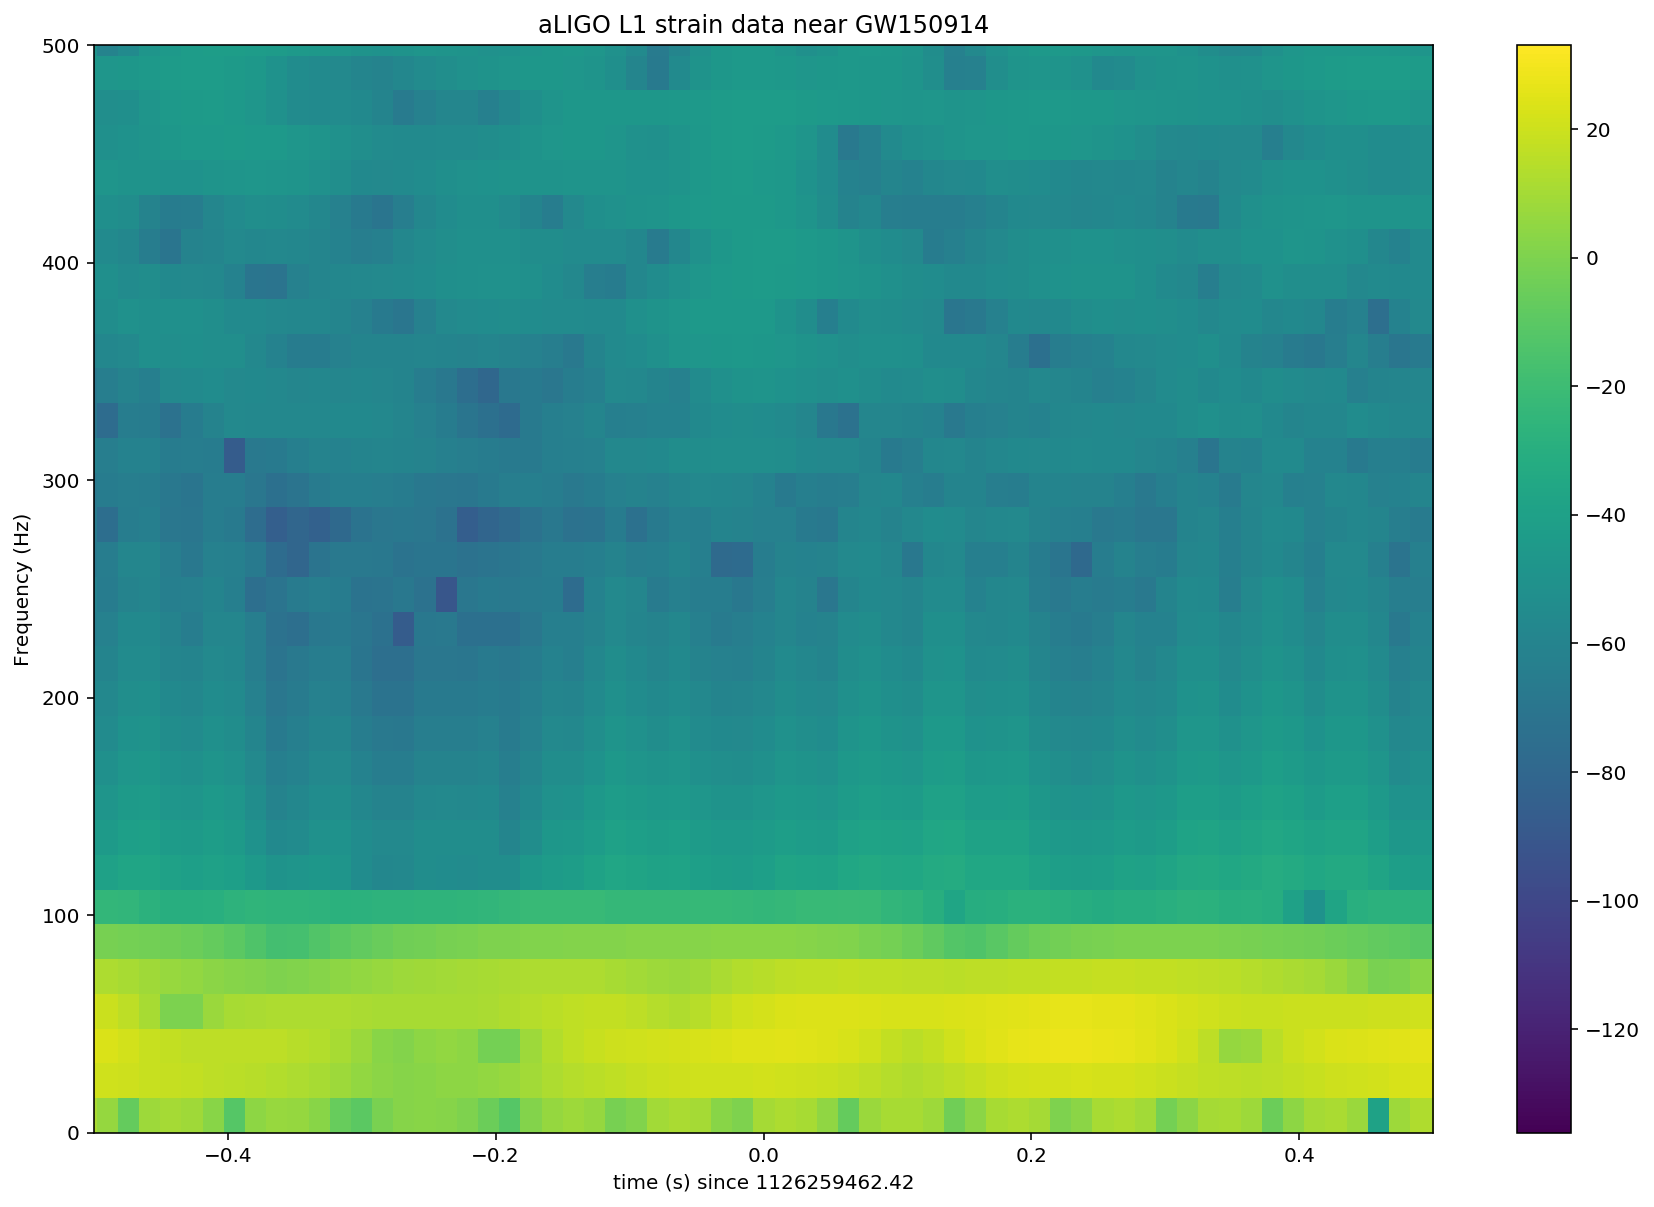

In [26]:
#  plot the whitened data, zooming in on the signal region:
tevent = 1126259462.422          # Mon Sep 14 09:50:45 GMT 2015 
deltat = 10.                      # seconds around the event
# index into the strain time series for this time interval:
indxt = np.where((time_H1 >= tevent-deltat) & (time_H1 < tevent+deltat))

# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = fs/16
# and with a lot of overlap, to resolve short-time features:
NOVL = NFFT*15/16
# and choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT)

# Plot the H1 whitened spectrogram around the signal
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_H1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])
plt.title('aLIGO H1 strain data near GW150914')
plt.savefig('GW150914_H1_spectrogram_whitened.png')

# Plot the L1 whitened spectrogram around the signal
plt.figure()
spec_H1, freqs, bins, im = plt.specgram(strain_L1_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])
plt.title('aLIGO L1 strain data near GW150914')
#plt.savefig('GW150914_L1_spectrogram_whitened.png')

#Time-domain filtering - Bandpassing+notching

Now let's filter the signal in the time domain, using bandpassing to reveal the signal in the frequency band [40 , 300 Hz], and notching of spectral lines to remove those noise sources from the data.

In [27]:
# generate linear time-domain filter coefficients, common to both H1 and L1.
# First, define some functions:

# This function will generate digital filter coefficients for bandstops (notches).
# Understanding it requires some signal processing expertise, which we won't get into here.
def iir_bandstops(fstops, fs, order=4):
    """ellip notch filter
    fstops is a list of entries of the form [frequency (Hz), df, df2]                           
    where df is the pass width and df2 is the stop width (narrower                              
    than the pass width). Use caution if passing more than one freq at a time,                  
    because the filter response might behave in ways you don't expect.
    """
    nyq = 0.5 * fs

    # Zeros zd, poles pd, and gain kd for the digital filter
    zd = np.array([])
    pd = np.array([])
    kd = 1

    # Notches
    for fstopData in fstops:
        fstop = fstopData[0]
        df = fstopData[1]
        df2 = fstopData[2]
        low = (fstop - df) / nyq
        high = (fstop + df) / nyq
        low2 = (fstop - df2) / nyq
        high2 = (fstop + df2) / nyq
        z, p, k = iirdesign([low,high], [low2,high2], gpass=1, gstop=6,
                            ftype='ellip', output='zpk')
        zd = np.append(zd,z)
        pd = np.append(pd,p)

    # Set gain to one at 100 Hz...better not notch there                                        
    bPrelim,aPrelim = zpk2tf(zd, pd, 1)
    outFreq, outg0 = freqz(bPrelim, aPrelim, 100/nyq)

    # Return the numerator and denominator of the digital filter                                
    b,a = zpk2tf(zd,pd,k)
    return b, a

def get_filter_coefs(fs):
    
    # assemble the filter b,a coefficients:
    coefs = []

    # bandpass filter parameters
    lowcut=43
    highcut=260
    order = 4

    # bandpass filter coefficients 
    nyq = 0.5*fs
    low = lowcut / nyq
    high = highcut / nyq
    bb, ab = butter(order, [low, high], btype='band')
    coefs.append((bb,ab))

    # Frequencies of notches at known instrumental spectral line frequencies.
    # You can see these lines in the ASD above, so it is straightforward to make this list.
    notchesAbsolute = np.array(
        [14.0,34.70, 35.30, 35.90, 36.70, 37.30, 40.95, 60.00, 
         120.00, 179.99, 304.99, 331.49, 510.02, 1009.99])

    # notch filter coefficients:
    for notchf in notchesAbsolute:                      
        bn, an = iir_bandstops(np.array([[notchf,1,0.1]]), fs, order=4)
        coefs.append((bn,an))

    # Manually do a wider notch filter around 510 Hz etc.          
    bn, an = iir_bandstops(np.array([[510,200,20]]), fs, order=4)
    coefs.append((bn, an))

    # also notch out the forest of lines around 331.5 Hz
    bn, an = iir_bandstops(np.array([[331.5,10,1]]), fs, order=4)
    coefs.append((bn, an))
    
    return coefs

# and then define the filter function:
def filter_data(data_in,coefs):
    data = data_in.copy()
    for coef in coefs:
        b,a = coef
        # filtfilt applies a linear filter twice, once forward and once backwards.
        # The combined filter has linear phase.
        data = filtfilt(b, a, data)
    return data



To visualize the effect of this filter, let's generate "white" gaussian noise, and filter it.

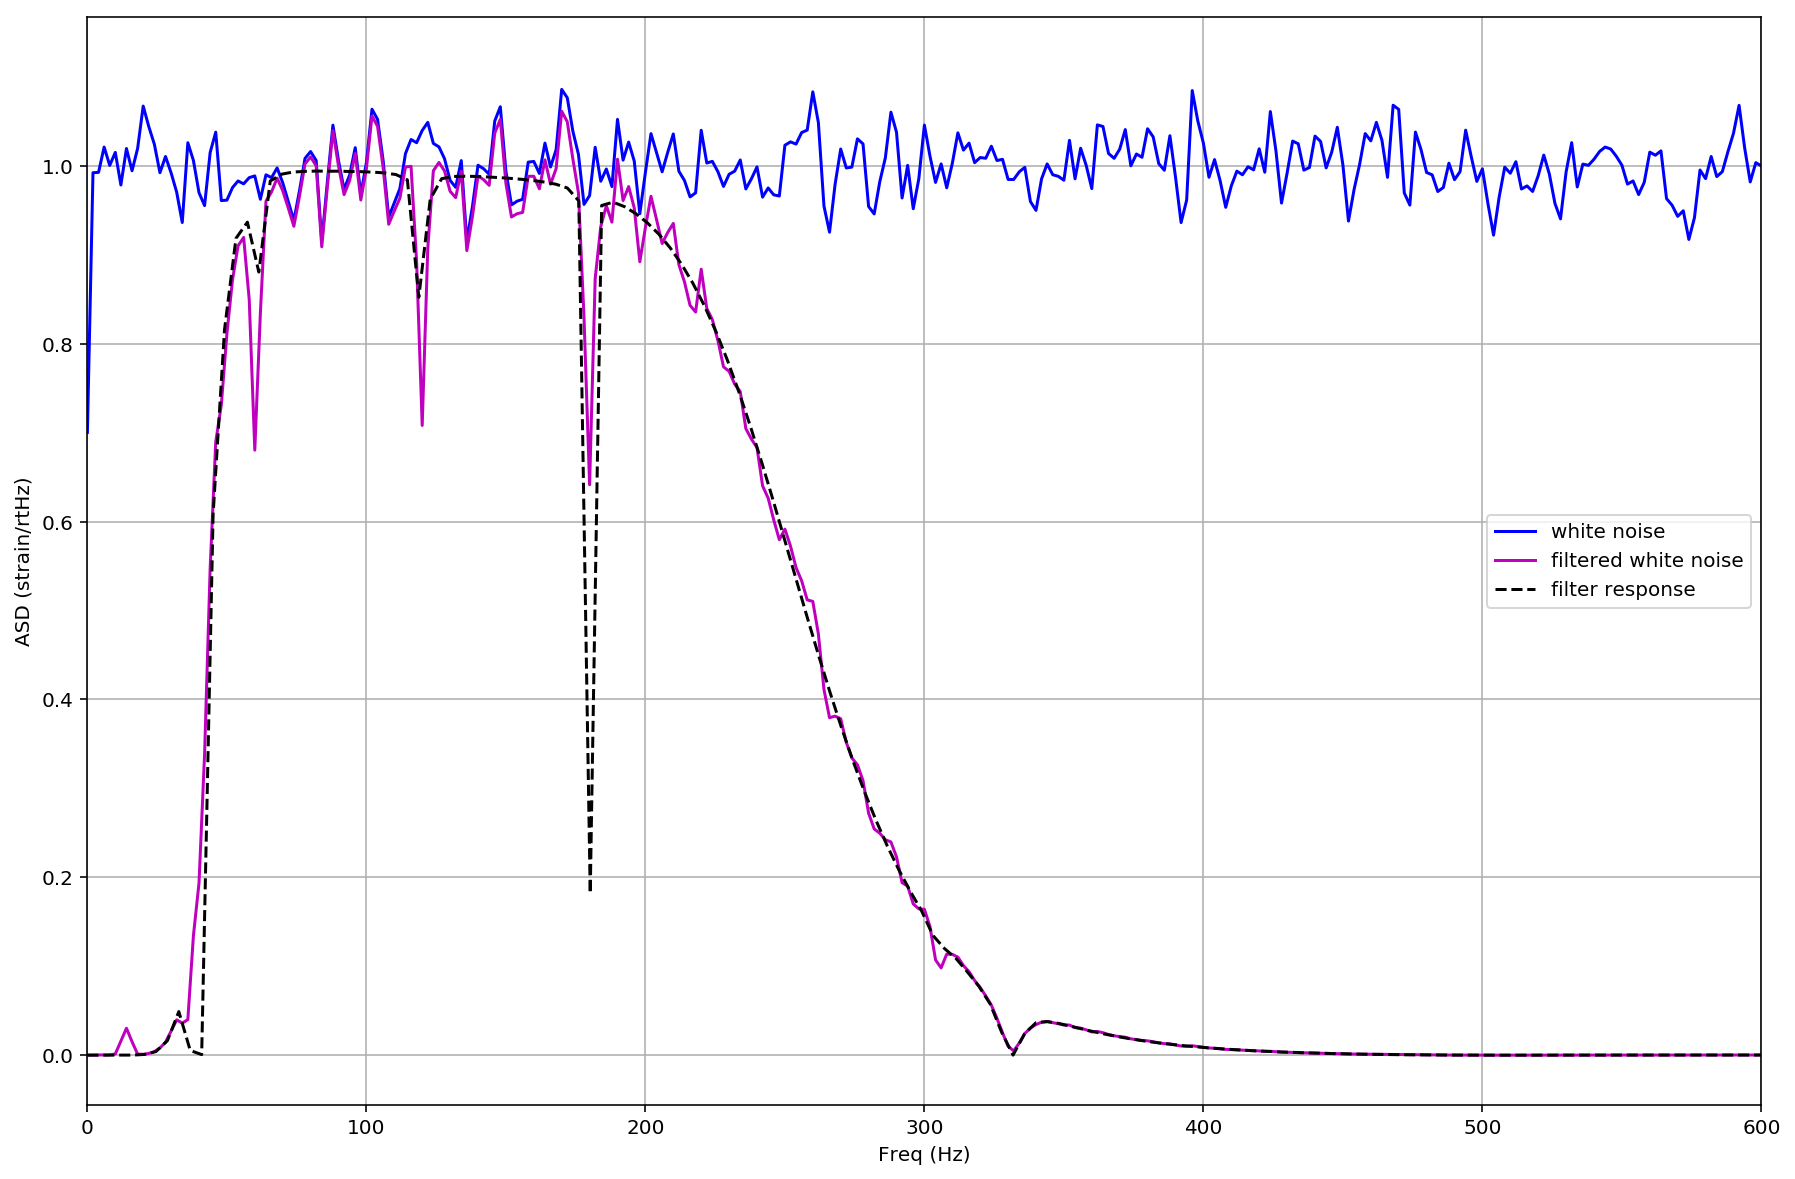

In [28]:
# get filter coefficients
coefs = get_filter_coefs(fs)

# generate random gaussian "data"
data = np.random.randn(128*fs)

# filter it:
resp = filter_data(data,coefs)

# compute the amplitude spectral density (ASD) of the original data, and the filtered data:
NFFT = fs/2
Pxx_data, freqs = mlab.psd(data, Fs = fs, NFFT = NFFT)
Pxx_resp, freqs = mlab.psd(resp, Fs = fs, NFFT = NFFT)

# The asd is the square root; and let's normalize it to 1:
norm = np.sqrt(Pxx_data).mean()
asd_data = np.sqrt(Pxx_data)/norm
asd_resp = np.sqrt(Pxx_resp)/norm

# get the predicted filter frequency response using signal.freqz:
Nc = 2000
filt_resp = np.ones(Nc)
for coef in coefs:
    b,a = coef
    w,r = signal.freqz(b,a,worN=Nc)
    filt_resp = filt_resp*np.abs(r)
freqf = (fs * 0.5 / np.pi) * w
# We "double pass" the filtering using filtfilt, so we square the filter response
filt_resp = filt_resp**2

# plot the ASDs
plt.figure()
plt.plot(freqs,  asd_data,'b',label='white noise')
plt.plot(freqs,  asd_resp,'m',label='filtered white noise')
plt.plot(freqf, filt_resp,'k--',label='filter response')
plt.xlim([0,600])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='center right')
#plt.savefig('GW150914_filter.png')


From the above, you can see that the gaussian noise (blue) is "white" - it is flat in frequency (all the way up to Nyquist frequency of 2048 Hz, but we'lve cut it off at 600 Hz to see the effect of filtering). You can see in the filtered data (magenta) the effects of the bandpassing and the notches.

Now let's filter the data, and plot the results:

Text(0.5,1,u'aLIGO FILTERED strain data near GW150914')

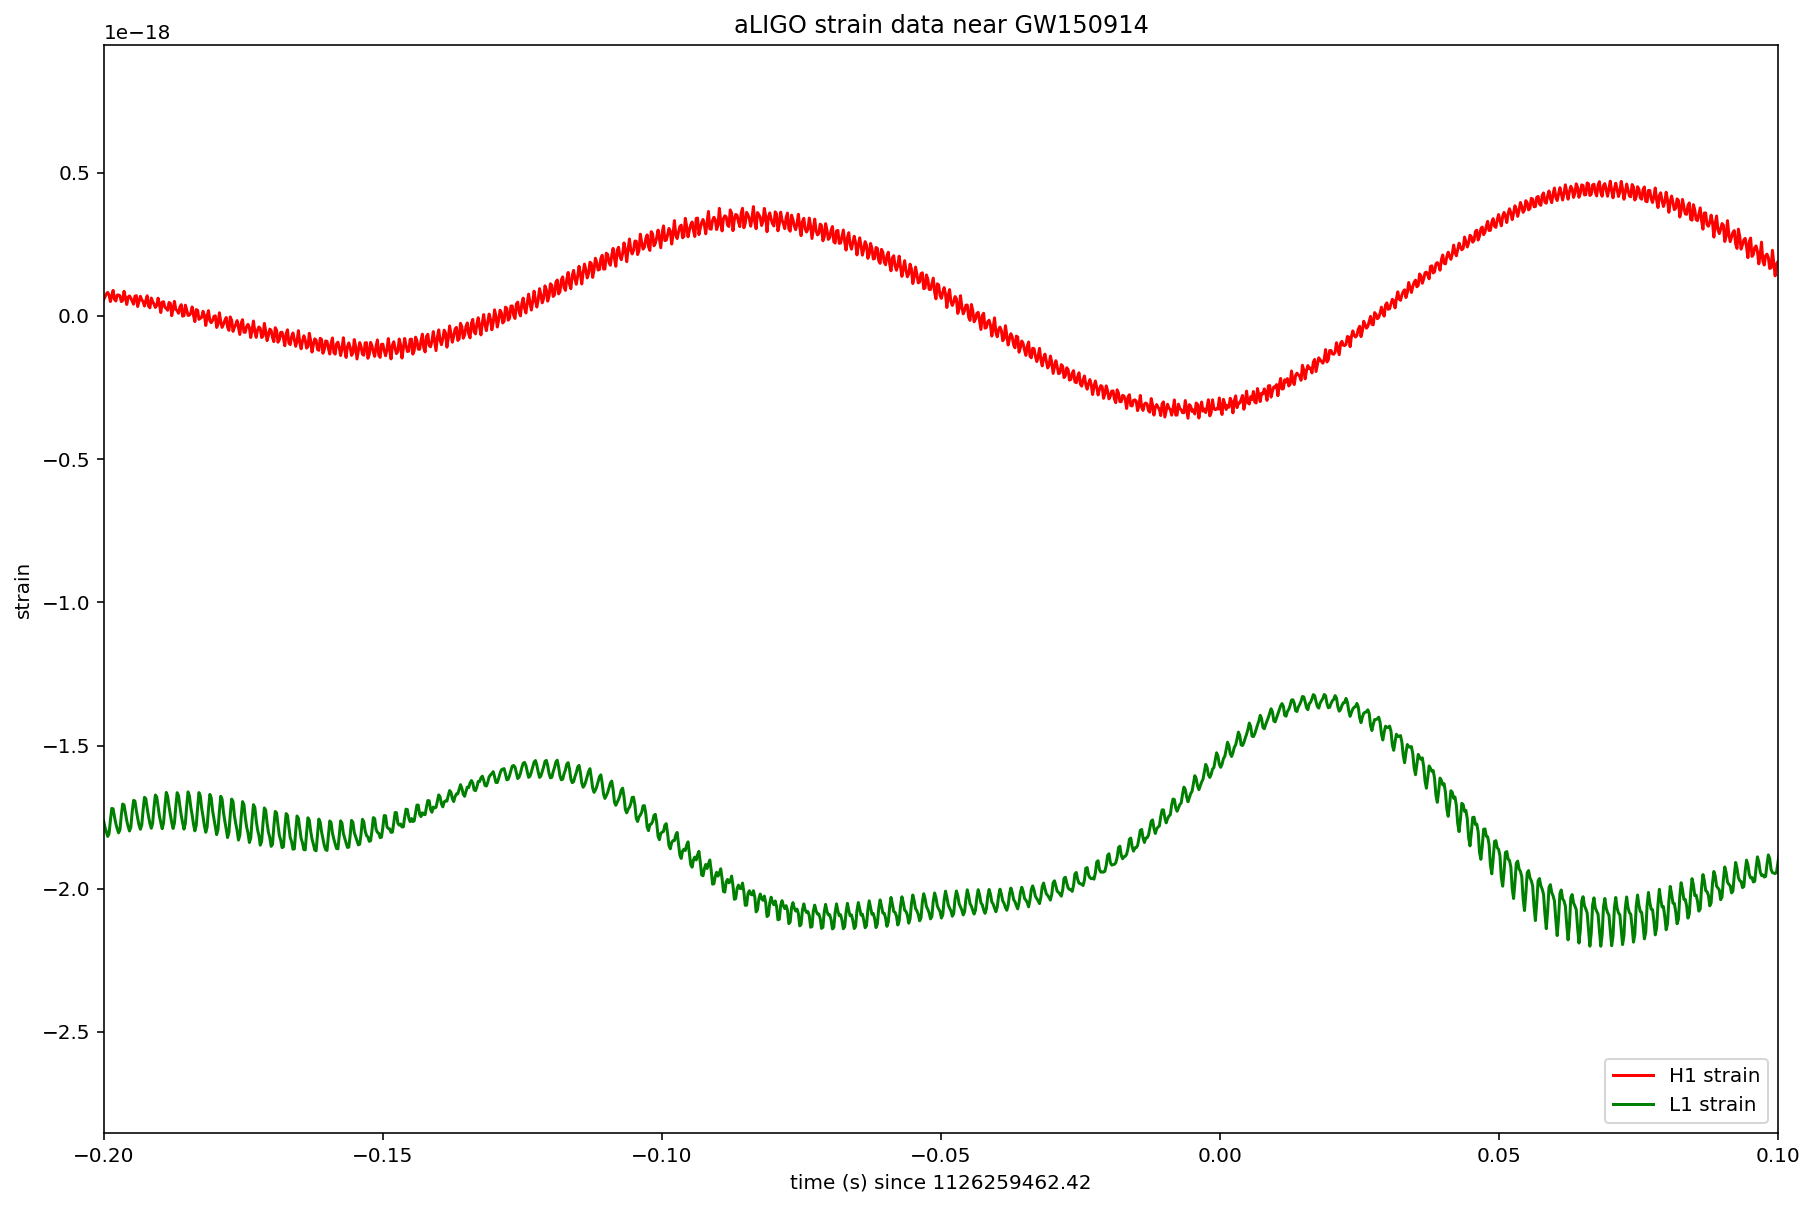

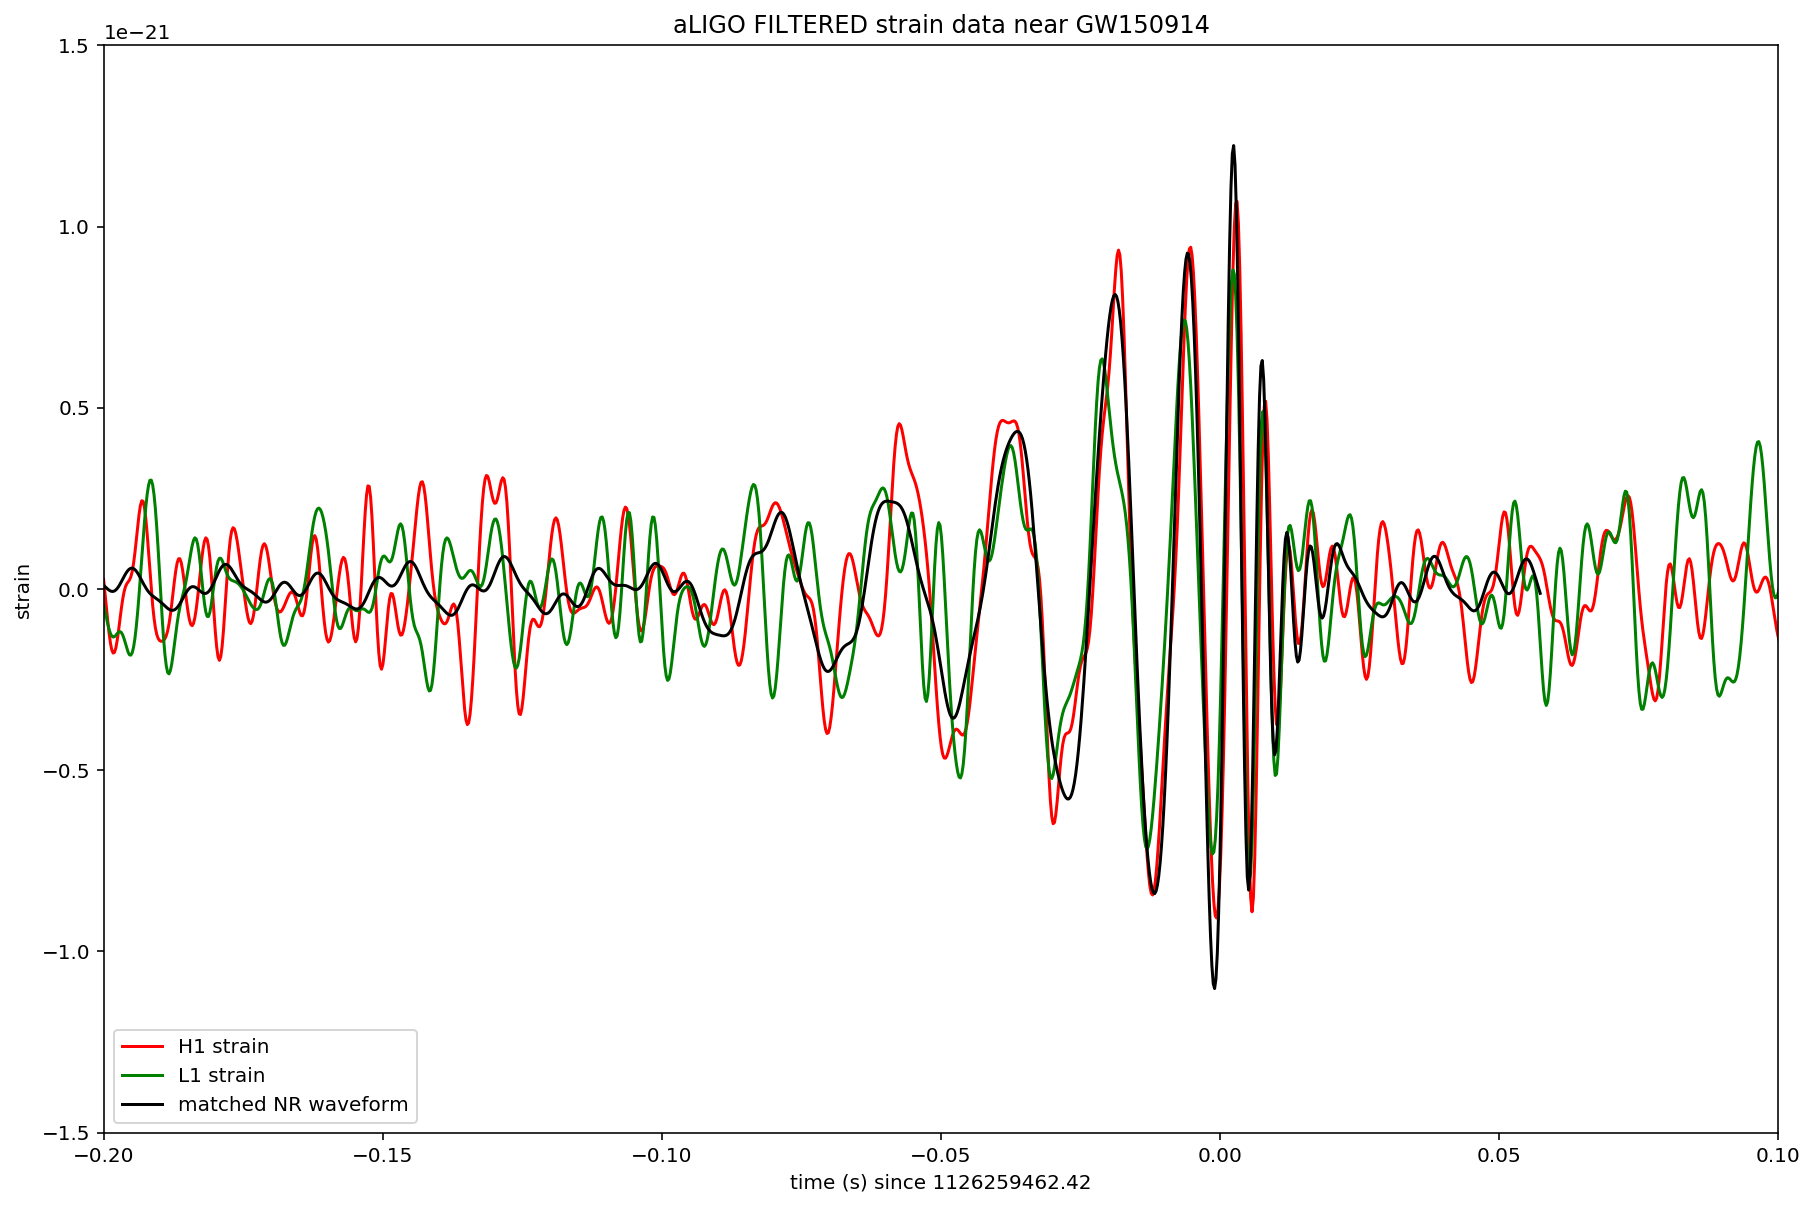

In [14]:
# filter the data:
strain_H1_filt = filter_data(strain_H1, coefs)
strain_L1_filt = filter_data(strain_L1, coefs)

# filter NR template as we do with the data:
NR_H1_filt = filter_data(NR_H1, coefs)

# plot the data prior to filtering:
plt.figure()
plt.plot(time-tevent,strain_H1,'r',label='H1 strain')
plt.plot(time-tevent,strain_L1,'g',label='L1 strain')
plt.xlim([-0.2,0.1])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower right')
plt.title('aLIGO strain data near GW150914')
plt.savefig('GW150914_H1_strain_unfiltered.png')

# plot the data after filtering:
# first, shift L1 by 7 ms, and invert. See the GW150914 detection paper for why!
strain_L1_fils = -np.roll(strain_L1_filt,int(0.007*fs))
# We also have to shift the NR template by 2 ms to get it to line up properly with the data
plt.figure()
plt.plot(time-tevent,strain_H1_filt,'r',label='H1 strain')
plt.plot(time-tevent,strain_L1_fils,'g',label='L1 strain')
plt.plot(NRtime+0.002,NR_H1_filt,'k',label='matched NR waveform')
plt.xlim([-0.2,0.1])
plt.ylim([-1.5e-21,1.5e-21])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('strain')
plt.legend(loc='lower left')
plt.title('aLIGO FILTERED strain data near GW150914')
#plt.savefig('GW150914_H1_strain_filtered.png')


# Make sound files

In [15]:
# make wav (sound) files from the whitened data, +-2s around the event.

from scipy.io import wavfile

# function to keep the data within integer limits, and write to wavfile:
def write_wavfile(filename,fs,data):
    d = np.int16(data/np.max(np.abs(data)) * 32767 * 0.9)
    wavfile.write(filename,int(fs), d)

tevent = 1126259462.422         # Mon Sep 14 09:50:45 GMT 2015 
deltat = 2.                     # seconds around the event

# index into the strain time series for this time interval:
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

# write the files:
write_wavfile("GW150914_H1_whitenbp.wav",int(fs), strain_H1_whitenbp[indxt])
write_wavfile("GW150914_L1_whitenbp.wav",int(fs), strain_L1_whitenbp[indxt])
write_wavfile("GW150914_NR_whitenbp.wav",int(fs), NR_H1_whitenbp)


In [16]:
# function that shifts frequency of a band-passed signal
def reqshift(data,fshift=100,sample_rate=4096):
    """Frequency shift the signal by constant
    """
    x = np.fft.rfft(data)
    T = len(data)/float(sample_rate)
    df = 1.0/T
    nbins = int(fshift/df)
    # print T,df,nbins,x.real.shape
    y = np.roll(x.real,nbins) + 1j*np.roll(x.imag,nbins)
    z = np.fft.irfft(y)
    return z

# parameters for frequency shift
fs = 4096
fshift = 400.
speedup = 1.
fss = int(float(fs)*float(speedup))

# shift frequency of the data
strain_H1_shifted = reqshift(strain_H1_whitenbp,fshift=fshift,sample_rate=fs)
strain_L1_shifted = reqshift(strain_L1_whitenbp,fshift=fshift,sample_rate=fs)
NR_H1_shifted = reqshift(NR_H1_whitenbp,fshift=fshift,sample_rate=fs)

# write the files:
write_wavfile("GW150914_H1_shifted.wav",int(fs), strain_H1_shifted[indxt])
write_wavfile("GW150914_L1_shifted.wav",int(fs), strain_L1_shifted[indxt])
write_wavfile("GW150914_NR_shifted.wav",int(fs), NR_H1_shifted)


#Downsampling from 16384 Hz to 4096 Hz

In [17]:
# read in the data at 16384 Hz and at 4096 Hz:
fn_16 = 'H-H1_LOSC_16_V1-1126259446-32.hdf5'
strain_16, time_16, chan_dict = rl.loaddata(fn_16, 'H1')
fn_4 = 'H-H1_LOSC_4_V1-1126259446-32.hdf5'
strain_4, time_4, chan_dict = rl.loaddata(fn_4, 'H1')

# Make PSDs of each:
fs = 16384
NFFT = 1*fs
Pxx_16, freqs_16 = mlab.psd(strain_16, Fs = fs, NFFT = NFFT)

fs = 4096
NFFT = 1*fs
Pxx_4, freqs_4 = mlab.psd(strain_4, Fs = fs, NFFT = NFFT)

fmin = 10
fmax = 8192

plt.figure()
plt.loglog(freqs_16, np.sqrt(Pxx_16),'b',label='strain at 16384')
plt.loglog(freqs_4,  np.sqrt(Pxx_4), 'm',label='strain at  4096')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')
#plt.savefig('GW150914_H1_ASD_16384.png')

TypeError: len() of unsized object